<a href="https://colab.research.google.com/github/WebheadTech/QCourse511-1/blob/main/FRQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up your Google Colab Environment**

Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Run this import command to be able to work with the eecs598 folder.

In [2]:
import sys
sys.path.append('/content/drive/My Drive/QCourse511/ResearchProject/working')

Run these commands if you have problems.  When you first start Google Colab notebook,a newer version of tensorflow will be installed, but you need tensorflow 2.5.1 (or 2.4.1 depending on the documentation you find).


In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip uninstall tensorflow-quantum

In [ ]:
!pip install tensorflow==2.5.1

In [ ]:
!pip install tf-nightly

In [ ]:
!pip install tensorflow-quantum

In [ ]:
!pip install tfq-nightly

In [ ]:
!pip install tensorflow-estimator==2.5.*

In [ ]:
!pip install keras==2.6.0

İmport some useful packages.

In [3]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import numpy as np


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Download, visualize and prepare the CIFAR10 dataset
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

The following code calls functions in the eecs598 library that use PyTorch to download the CIFAR dataset, split it into train and test sets and then convert it to torch.Tensors which are a multi-dimensional matrix containing elements of a single data type.

The code in the eecs598 library also normalizes pixel values to be between 0 and 1 by dividing by 255.

In [ ]:
x_train, y_train, x_test, y_test = eecs598.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


Increase the default figure size.

In [ ]:
# Control qrid size for visualization
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Visualize the dataset

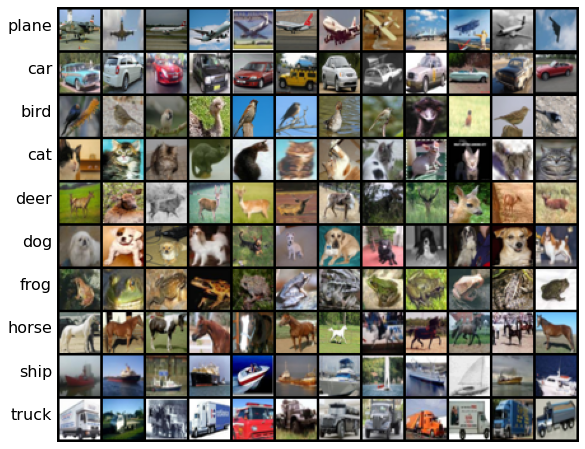

In [ ]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(eecs598.tensor_to_image(img))
plt.axis('off')
plt.show()

# Label data
The label data is a list of numbers ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.

0 - airplane, 
1 - automobile, 
2 - bird, 
3 - cat, 
4 - deer, 
5 - dog, 
6 - frog, 
7 - horse, 
8 - ship, 
9 - truck

In [ ]:
print(y_train)

tensor([6, 9, 9,  ..., 9, 1, 1])


# 1. Data preparation
You will begin by preparing the CIFAR-10 dataset for running on a quantum computer.

# 1.1 Download the CIFAR-10 dataset
The first step is to get the traditional the CIFAR-10 dataset. This can be done using the `tf.keras.datasets` module.

In [ ]:
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
train_images, test_images = train_images/255.0, test_images/255.0

In [ ]:
y_train=train_labels.flatten()
y_test=test_labels.flatten()
# We have reduced the dimension of the labels

It really comes down to math and getting a value between 0-1. Since 255 is the maximum value, dividing by 255 expresses a 0-1 representation. Each channel (Red, Green, and Blue are each channels) is 8 bits, so they are each limited to 256, in this case 255 since 0 is included.

In [ ]:
x_train=tf.image.rgb_to_grayscale(train_images)
x_test=tf.image.rgb_to_grayscale(test_images)
#to convert images to grayscale

Restrict our dataset to those of only two ground truth labels: cat and frog.  Filter the dataset to keep just the cat  and frog, remove the other classes. At the same time convert the label, y, to boolean: True for 3 (cat) and False for 6 (frog).

In [ ]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

# The lable data is now a mix of True and False values, True for a cat and False for a frog.
print(y_train)

Number of filtered training examples: 10000
Number of filtered test examples: 2000
[False  True  True ...  True  True False]


In [ ]:
# Let's reduce the size of the data set to 1000 training data points and 200 testing data points.
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


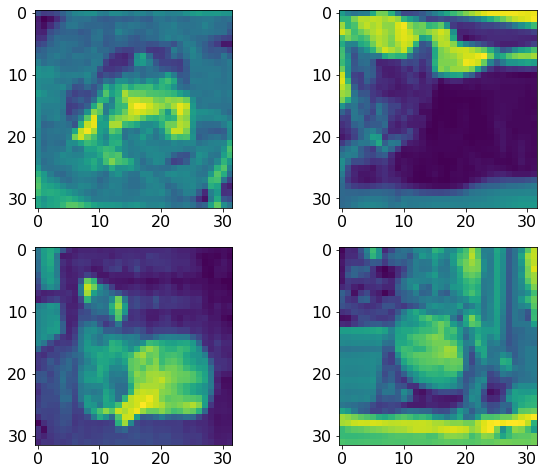

In [ ]:
# Review the first four of the images in 32x32 mode
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[0, :, :, 0])
axarr[0,1].imshow(x_train[1, :, :, 0])
axarr[1,0].imshow(x_train[2, :, :, 0])
axarr[1,1].imshow(x_train[3, :, :, 0])

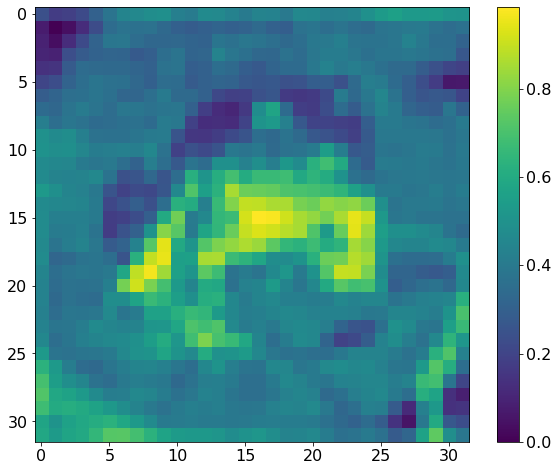

In [ ]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

Resize the image 32x32 to down to 2x2 as that is what our FRQI example can work with.  This can be done using bilinear interpolation as another option.

In [ ]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

#DATASET_DIM = 10
#x_train_s, x_test_s = truncate_x(x_train, x_test, n_components=DATASET_DIM)
#print(f'New datapoint dimension:', len(x_train_s[0]))

image_dimension = 2
x_train_s = tf.image.resize(x_train, (image_dimension,image_dimension)).numpy()
x_test_s = tf.image.resize(x_test, (image_dimension,image_dimension)).numpy()

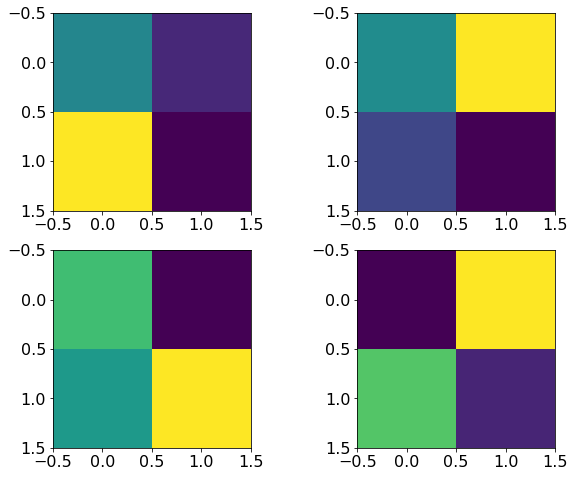

In [ ]:
# Review the first four of the images in 32x32 mode
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train_s[0, :, :, 0])
axarr[0,1].imshow(x_train_s[1, :, :, 0])
axarr[1,0].imshow(x_train_s[2, :, :, 0])
axarr[1,1].imshow(x_train_s[3, :, :, 0])

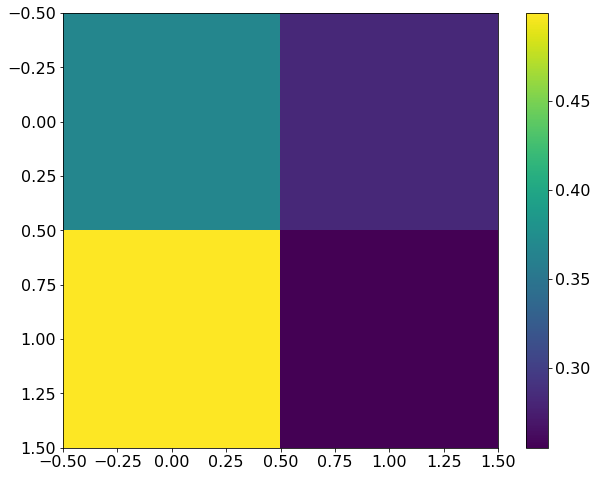

In [ ]:
plt.imshow(x_train_s[0, :, :, 0])
# The color bar is getting adjusted for some reason.  May be a bug with tf.image.resize() which has some underlying problems.
# https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
plt.colorbar()

## Encode the data as quantum circuits
+ Set the base state based on the pixel
+ run through the algorithm

Transform the images to black and white by thresholding the pixel color.



In [ ]:
print(x_train_s[0:4,0:4])

THRESHOLD = 0.5

x_train_bin = np.array(x_train_s > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_s > THRESHOLD, dtype=np.float32)

print(x_train_bin[0:4,0:4])

[[[[0.36764815]
   [0.28288433]]

  [[0.49960423]
   [0.25495717]]]


 [[[0.35545862]
   [0.6398164 ]]

  [[0.2035408 ]
   [0.08488853]]]


 [[[0.5119202 ]
   [0.21370961]]

  [[0.44399855]
   [0.6437518 ]]]


 [[[0.18349177]
   [0.434492  ]]

  [[0.36693138]
   [0.2093106 ]]]]
[[[[0.]
   [0.]]

  [[0.]
   [0.]]]


 [[[0.]
   [1.]]

  [[0.]
   [0.]]]


 [[[1.]
   [0.]]

  [[0.]
   [1.]]]


 [[[0.]
   [0.]]

  [[0.]
   [0.]]]]


The qubits at pixel indices with values that exceed a threshold, are rotated through a gate.  This is the part we should replace.

In [ ]:
def FRQI(theta):

    circuit = cirq.Circuit()

    theta = theta

    # Or created in a range
    # This will create LineQubit(0), LineQubit(1), LineQubit(2)
    q0, q1, q2 = cirq.LineQubit.range(3)

    circuit.append(cirq.H(q) for q in cirq.LineQubit.range(2))

    qc.barrier()
    #Pixel 1

    qc.cry(theta,0,2)
    qc.cx(0,1)
    qc.cry(-theta,1,2)
    qc.cx(0,1)
    qc.cry(theta,1,2)

    qc.barrier()
    #Pixel 2

    qc.x(1)
    qc.cry(theta,0,2)
    qc.cx(0,1)
    qc.cry(-theta,1,2)
    qc.cx(0,1)
    qc.cry(theta,1,2)

    qc.barrier()

    qc.x(1)
    qc.x(0)
    qc.cry(theta,0,2)
    qc.cx(0,1)
    qc.cry(-theta,1,2)
    qc.cx(0,1)
    qc.cry(theta,1,2)


    qc.barrier()

    qc.x(1)

    qc.cry(theta,0,2)
    qc.cx(0,1)
    qc.cry(-theta,1,2)
    qc.cx(0,1)
    qc.cry(theta,1,2)

    qc.measure_all()

    qc.draw()


FRQI(0)


NameError: ignored

In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(6, 6)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.H(qubits[i]))

    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [ ]:
SVGCircuit(x_train_circ[0])


ValueError: ignored

Convert  Cirq circuits to tensors for tfq

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## Quantum neural network

add a layer of these gates to a circuit

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)


In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)


In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [ ]:
model_circuit, model_readout = create_quantum_model()


 Build the Keras model.


In [ ]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0


In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])



In [ ]:
print(model.summary())

In [ ]:
EPOCHS = 3
BATCH_SIZE = 128

NUM_EXAMPLES = len(x_train_tfcirc)



In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]



In [ ]:
import time
start_time = time.time()

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)



In [ ]:
qnn_accuracy = qnn_results[1]
qnn_accuracy


In [ ]:
model.predict_classes(x_train_tfcirc[0:7])

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

for i in range(3):
  for j in range(3):
    ax = fig.add_subplot(gs[i, j])
    
    ax.imshow(x_train[i+j, :, :, 0])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()



In [ ]:
plt.plot(qnn_history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()